# Example notebook Peak Removal Filter

In this notebook it is shown how to use the different functions of the Peak Removal Filter.

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr

import pypwsqc.peak_removal_filter as prf
import pypwsqc.peak_removal_filter_plots as prfp

## Data download and preparation

In [ ]:
print("Your current directory:", Path.cwd())

In this example, we use an open PWS dataset from Amsterdam, published by de Vos et al. (2019). By running the cell below, a NetCDF-file will be downloaded to your current repository (if your machine is connected to the internet).

You can specify the directory and the name for the test dataset in the next cell.

In [46]:
name = "test_dataset_prf.nc"
path = Path.cwd() / "data" / name  # or specify your own directory

In [47]:
if path.exists():
    print(f"File {name} already exists in the current directory.")
else:
    !curl -o "$path" -L https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc

File test_dataset_prf.nc already exists in the current directory.


### Use your own data
If you want to use your own datasets, undo the commenting and enter your own path as name. 

Later, there are also options to use a second reference dataset. You can make use of that by adding a path to a second dataset to name_ref.

In [48]:
# name =
# name_ref =

## Load data

In [49]:
ds_test = xr.open_dataset(path)
# ds_test_ref = xr.open_dataset(name_ref) # undo comment to use reference dataset

In [50]:
ds_test

<xarray.Dataset> Size: 237MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 2kB ...
    latitude   (id) float64 1kB ...
    longitude  (id) float64 1kB ...
Data variables:
    rainfall   (id, time) float64 235MB ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [51]:
# ds_test_ref

## Convert coordinates if necessary
For the functions to work, we need x and y coordinates in utm32, therefore, we have to convert latitude and longitude.

If your dataset already contains x and y in utm32, you can skip this step.

In [52]:
ds_test = prf.add_proj_coords_to_ds(
    ds_test, "longitude", "latitude", "EPSG:25831"
)  # UTM zone 31N
# ds_test_ref = prf.add_proj_coords_to_ds(
#     ds_test_ref, "longitude", "latitude", "EPSG:25831"
# ) # undo comment to use reference dataset

In [53]:
ds_test

<xarray.Dataset> Size: 237MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 2kB ...
    latitude   (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    longitude  (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x          (id) float64 1kB 6.139e+05 6.142e+05 ... 6.392e+05 6.396e+05
    y          (id) float64 1kB 5.796e+06 5.796e+06 ... 5.797e+06 5.792e+06
Data variables:
    rainfall   (id, time) float64 235MB ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [55]:
# ds_test_ref

## Select parameters and example station for peak removal
You can select the station on which you want to apply the Peak Removal Filter, the maximum distance in which to search for neighboring stations, the maximum allowed number of neighboring stations, and the quantile for which values should be considered peaks.

In [56]:
station = "ams69"
max_distance = 3000
n_closest = 25
quantile = 0.99

For clarification:

If we use the same dataset as a reference as the one we are trying to remove the peaks from, this and all results are denoted as aa_.... For example, our example station is a pws, and we consider other pws as their neighbors.

If we use different datasets, this is denoted as ab_.... For example, pws and pluvio.

## Get the closest neighbors of the example station
This is basically the get_closest_points_to_point function from the poligrain.spatial package. It gives the n_closest neighbors for every station and their distances.

The naming goes aa_... because we used ds_test both for ds_points and for ds_points_neighbors.

In [57]:
aa_closest_neighbors = prf.get_closest_points_to_point(
    ds_points=ds_test,
    ds_points_neighbors=ds_test,
    max_distance=max_distance,
    n_closest=n_closest,
)
# ab_closest_neighbors = prf.get_closest_points_to_point(
#     ds_points=ds_test,
#     ds_points_neighbors=ds_test_ref,
#     max_distance=max_distance,
#     n_closest=n_closest
# )

In [58]:
aa_closest_neighbors.sel(id=station).distance.to_numpy()

array([   0.        ,  828.2976947 , 1046.30793922, 1496.14875323,
       1805.70567627, 1860.2321871 , 1863.46825025, 1872.87095353,
       1940.15677629, 2334.29865476, 2469.22382046, 2655.46798239,
       2775.38896647, 2789.41262656, 2791.87356269,           inf,
                 inf,           inf,           inf,           inf,
                 inf,           inf,           inf,           inf,
                 inf])

Here is our example station selected. It shows the distances for the neighbors. The first distance is 0 because it is a reference to the example station itself. If there are fewer stations found than n_closest, the remaining slots become inf.

## Identify the peaks and nan sequences
This we only do for the main dataset on which we want to remove the peaks.

In [59]:
time_peak_lst, seq_start_lst, seq_end_lst, seq_len_lst = prf.get_nan_sequences(
    dataset=ds_test, station=station, quantile=quantile, seq_len_threshold=0
)

Check peaks for leading nans: 100%|██████████| 465/465 [00:00<00:00, 2161.11 peaks/s]


As a result of the get_nan_sequences function, we get a list with the time stamps of the peaks, the start times of the nan sequences before the peaks, the end times of the nan sequences before the peaks, and the length of the nan sequences before the peaks. In the next cell, there is an example.

In [60]:
print(
    f"The station {station} has {len(time_peak_lst)} peaks with a leading nan sequence.\n"
)
print(f"The first peak is at {time_peak_lst[0]}.\n")
print(f"The leading nan sequence of this peak starts at {seq_start_lst[0]}.\n")
print(f"The leading nan sequence of this peak ends at {seq_end_lst[0]}.\n")
print(f"The leading nan sequence of this peak has a length of {seq_len_lst[0]}.\n")

The station ams69 has 28 peaks with a leading nan sequence.

The first peak is at 2017-06-27T23:35:00.000000000.

The leading nan sequence of this peak starts at 2017-06-27T23:20:00.000000000.

The leading nan sequence of this peak ends at 2017-06-27T23:30:00.000000000.

The leading nan sequence of this peak has a length of 3.



## Print info
This gives just some info about the data.

In [61]:
prf.print_info(
    dataset=ds_test,
    station=station,
    max_distance=max_distance,
    n_closest=n_closest,
    quantile=quantile,
    time_peak_lst=time_peak_lst,
    seq_len_lst=seq_len_lst,
    aa_closest_neighbors=aa_closest_neighbors,
    ab_closest_neighbors=None,  # Here you could enter the closest neighbors considering the reference dataset ds_test_ref
);

station: ams69 

max_distance: 3000 m
n_closest: 25
0.99-quantile: 0.303 mm 

number of peaks with nan sequence: 28
average length of the nan sequences: 5.93
percentage "peak nans" of total nan values: 0.11 % 

pws neighbors found: 14
reference neighbors found: 0


## Plot stations

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


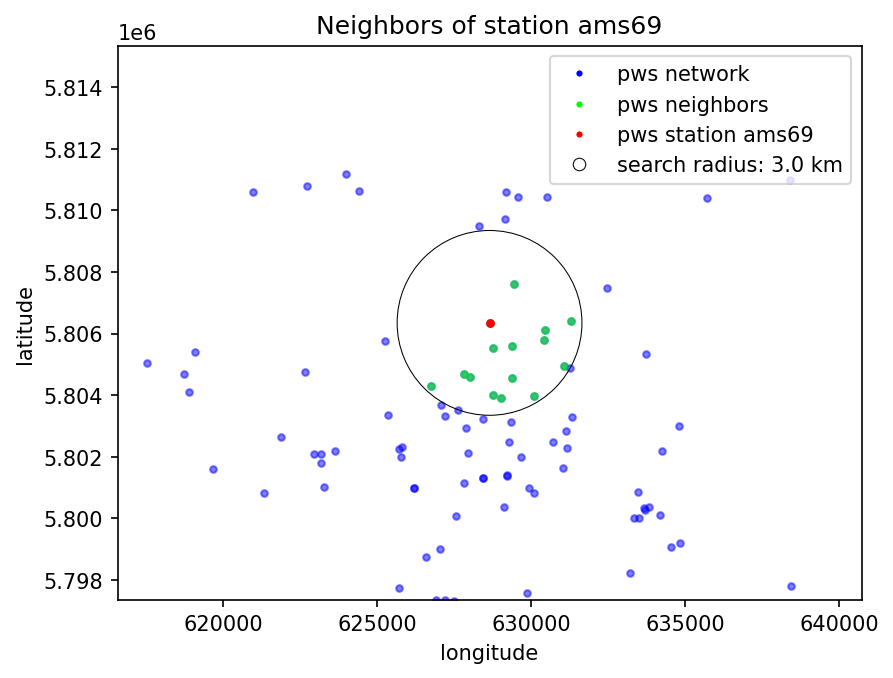

In [62]:
prfp.plot_station_neighbors(
    a_dataset=ds_test,
    b_dataset=None,  # Here you could enter the reference dataset ds_test_ref
    station=station,
    aa_closest_neighbors=aa_closest_neighbors,
    ab_closest_neighbors=None,  # Here you could enter the closest neighbors considering the reference dataset ds_test_ref
    max_distance=max_distance,
    zoom=True,
);

## Inverse distance weighting
Here we calculate the weights of the neighbors for all stations. The previously determined closest neighbors of the example station are needed.

In [63]:
aa_weights_da = prf.inverse_distance_weighting(closest_neighbors=aa_closest_neighbors)
# ab_weights_da = prf.inverse_distance_weighting(
#     closest_neighbors=ab_closest_neighbors
# )

Calculate weights for stations: 100%|██████████| 134/134 [00:00<00:00, 2650.44 stations/s]


In [64]:
aa_weights_da.sel(id=station).to_numpy()

array([0.        , 0.28422892, 0.17812387, 0.08711474, 0.05980634,
       0.05635168, 0.05615613, 0.05559369, 0.0518045 , 0.03578725,
       0.03198308, 0.02765407, 0.0253159 , 0.025062  , 0.02501783,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Here is our example station selected. It shows the weights for the neighbors. The first weight is 0 because it is a reference to the example station itself. If there are fewer stations found than n_closest, the remaining slots become 0. The sum of all weights is 1.

## Interpolate precipitation
Here we interpolate the precipitation of the closest neighbors to the example station to get the "precipitation shape" for the example station, with which we can later distribute the peak.

In [65]:
aa_lst_seqs = prf.interpolate_precipitation(
    dataset=ds_test,
    station=station,
    closest_neighbors=aa_closest_neighbors,
    weights_da=aa_weights_da,
    seq_start_lst=seq_start_lst,
    time_peak_lst=time_peak_lst,
    seq_len_lst=seq_len_lst,
    seq_nan_threshold=0.3,
    min_station_threshold=3,
)
# ab_lst_seqs = prf.interpolate_precipitation(
#     dataset=ds_test_ref,
#     station=station,
#     closest_neighbors=ab_closest_neighbors,
#     weights_da=ab_weights_da,
#     seq_len_lst=seq_start_lst,
#     time_peak_lst=time_peak_lst,
#     seq_len_lst=seq_len_lst,
#     seq_nan_threshold=0.5,
#     min_station_threshold=1
# )

Interpolate precipitation values for sequences: 100%|██████████| 28/28 [00:00<00:00, 11753.45 sequences/s]


In some cases, there will not be calculated a "precipitation shape" because there are too many nans in the neighboring stations time series or there are too few stations with data available for the specific nan sequence of the example station. 

If you still want a "precipitation shape", you can set the seq_nan_threshold higher and/or the min_station_threshold lower. 

### Plot nan sequence
In the next cell, select the peak you want to plot.

In [66]:
peak_num = 3  # --> actually, this is the peak number (peak_num + 1)

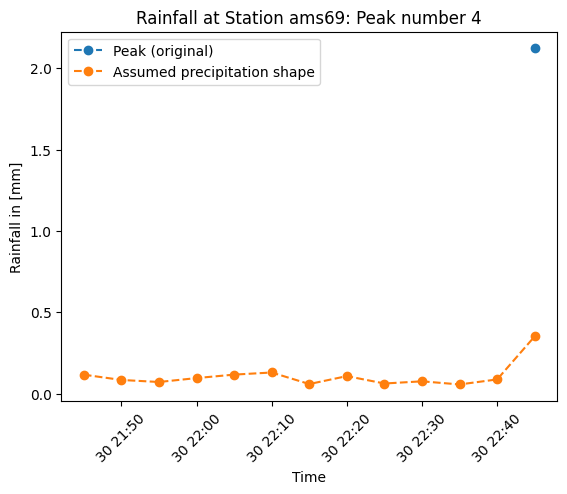

In [67]:
start = seq_start_lst[peak_num]
end = time_peak_lst[peak_num]

plt.plot(
    ds_test.sel(id=station).time.sel(time=slice(start, end)),
    ds_test.sel(id=station).rainfall.sel(time=slice(start, end)),
    label="Peak (original)",
    marker="o",
    linestyle="--",
)

plt.plot(
    ds_test.sel(id=station).time.sel(time=slice(start, end)),
    aa_lst_seqs[peak_num],
    label="Assumed precipitation shape",
    marker="o",
    linestyle="--",
)

plt.xlabel("Time")
plt.ylabel("Rainfall in [mm]")
plt.title(f"Rainfall at Station {station}: Peak number {peak_num + 1}")
plt.xticks(rotation=45)
plt.legend();

In the plot we can see the peak as a single blue point because it has only nan values before and the "precipitation shape", obtained through interpolation of the precipitation values of the neighboring stations to the example station.

## Distribute the peak
Here, we distribute the peak to the time stamps of the leading nan sequence by using the "precipitation shape" of the interpolated precipitation values of the neighboring stations.

In [68]:
aa_seqs_corr_lst = prf.distribute_peak(
    dataset=ds_test, station=station, time_peak_lst=time_peak_lst, seqs_lst=aa_lst_seqs
)
# ab_seqs_corr_lst = prf.distribute_peak(
#     dataset=ds_test,
#     station=station,
#     time_peak_lst=time_peak_lst,
#     seqs_lst=ab_lst_seqs
# )

Distribute peaks: 100%|██████████| 28/28 [00:00<00:00, 634.11 peaks/s]


### Plot nan sequence

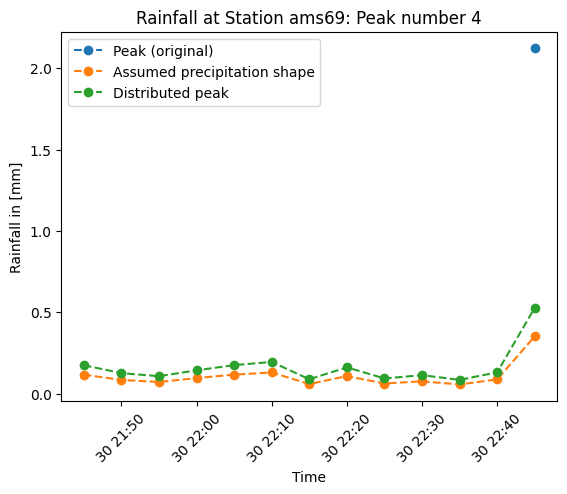

In [69]:
start = seq_start_lst[peak_num]
end = time_peak_lst[peak_num]
plt.plot(
    ds_test.sel(id=station).time.sel(time=slice(start, end)),
    ds_test.sel(id=station).rainfall.sel(time=slice(start, end)),
    label="Peak (original)",
    marker="o",
    linestyle="--",
)
plt.plot(
    ds_test.sel(id=station).time.sel(time=slice(start, end)),
    aa_lst_seqs[peak_num],
    label="Assumed precipitation shape",
    marker="o",
    linestyle="--",
)
plt.plot(
    ds_test.sel(id=station).time.sel(time=slice(start, end)),
    aa_seqs_corr_lst[peak_num],
    label="Distributed peak",
    marker="o",
    linestyle="--",
)
plt.xlabel("Time")
plt.ylabel("Rainfall in [mm]")
plt.title(f"Rainfall at Station {station}: Peak number {peak_num + 1}")
plt.xticks(rotation=45)
plt.legend();

This is the same plot as above, but the amount of precipitation from the peak is distributed to the nan values by using the "precipitation shape" to know what portion of the peak to put on each nan value.

## Overwrite nan sequence
Here we just overwrite the nan sequences for which we were able to distribute the peaks.

If there was available a second reference dataset, and it was used for calculations, you could use its outcome (ab_seqs_corr_lst) to overwrite the dataset.

In [70]:
data_corr = prf.overwrite_seq(
    dataset=ds_test,
    station=station,
    seqs_corr_lst=aa_seqs_corr_lst,
    seq_start_lst=seq_start_lst,
    time_peak_lst=time_peak_lst,
)

Overwrite sequences: 100%|██████████| 28/28 [00:00<00:00, 2167.48 sequences/s]


## Plot the results

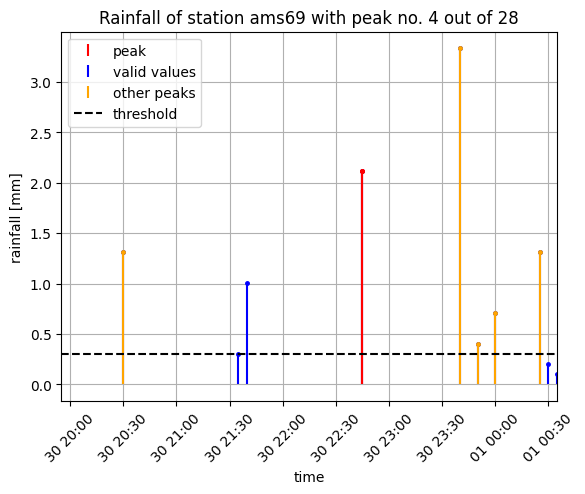

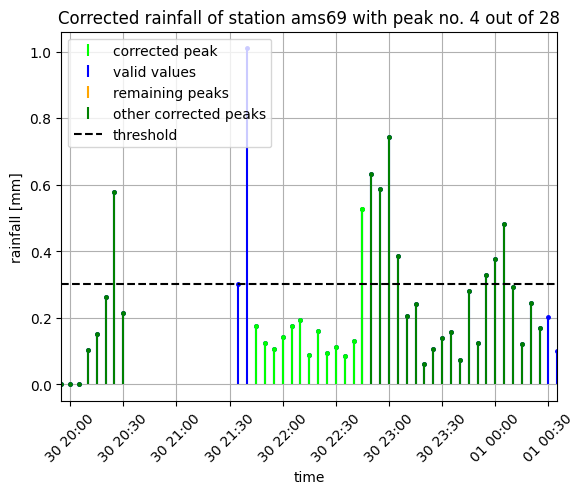

In [71]:
prfp.plot_peak(
    dataset=ds_test,
    data_corr=None,
    station=station,
    quantile=quantile,
    peak_num=peak_num,
    seq_start_lst=seq_start_lst,
    time_peak_lst=time_peak_lst,
    seq_end_lst=seq_end_lst,
    seq_len_lst=seq_len_lst,
    data_is_corrected=False,
    zoom_out=10,
)
prfp.plot_peak(
    dataset=ds_test,
    data_corr=data_corr,
    station=station,
    quantile=quantile,
    peak_num=peak_num,
    seq_start_lst=seq_start_lst,
    time_peak_lst=time_peak_lst,
    seq_end_lst=seq_end_lst,
    seq_len_lst=seq_len_lst,
    data_is_corrected=True,
    zoom_out=10,
);